**<font size="6"> Prédictions des modèles SARIMA retenus </font>**

# Imports des modules et fonctions nécessaires

In [33]:
import os
import re
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pylab import rcParams
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import itertools
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning) # Permet d'éviter l'affichage des Warnings

# Chargement et nettoyage des données

In [34]:
df = pd.read_pickle("data/df_train.pkl")
df_ACE = df[df['filename']=='champs-elysees.csv']
df_Sts = df[df['filename']=='convention.csv']
df_convention = df[df['filename']=='sts.csv']

df_test = pd.read_pickle("data/df_test.pkl")
df_ACE_test = df_test[df_test['filename']=='champs-elysees.csv']
df_Sts_test = df_test[df_test['filename']=='convention.csv']
df_convention_test = df_test[df_test['filename']=='sts.csv']


dfs = [df_ACE, df_Sts, df_convention]
dfs_test = [df_ACE_test, df_Sts_test, df_convention_test]

## Traitement des dates

In [35]:
# Format d'une série temporelle
for df in dfs:
    df['Date et heure de comptage']= pd.to_datetime(df["Date et heure de comptage"], format='%Y-%m-%d %H:%M:%S')
    
# for df in dfs_test:
#     df['Date et heure de comptage']= pd.to_datetime(df["Date et heure de comptage"], format='%Y-%m-%d %H:%M:%S')
    
# Lignes rangées par ordre chronologique
for df in dfs:
    df.sort_values("Date et heure de comptage",inplace = True)
    
for df in dfs_test:
    df.sort_values("Date et heure de comptage",inplace = True)

def index_and_freq(df):
    df = df.set_index('Date et heure de comptage')
    df = df.asfreq('H', method= 'ffill')
    return df

tagg = ['Champs-Élysées', 'Convention', 'Sts-Pères']
    
# Nous indiquons que la série temporelle est indexée selon la date
df_ACE = index_and_freq(df_ACE)
df_convention = index_and_freq(df_convention)
df_Sts = index_and_freq(df_Sts)

df_ACE_test = index_and_freq(df_ACE_test)
df_Sts_test = index_and_freq(df_Sts_test)
df_convention_test = index_and_freq(df_convention_test)


C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [36]:
df_ACE['Débit horaire']

Date et heure de comptage
2019-11-01 04:00:00     746.0
2019-11-01 05:00:00     549.0
2019-11-01 06:00:00     503.0
2019-11-01 07:00:00     500.0
2019-11-01 08:00:00     525.0
                        ...  
2020-12-10 20:00:00    1038.0
2020-12-10 21:00:00     699.0
2020-12-10 22:00:00     474.0
2020-12-10 23:00:00     403.0
2020-12-11 00:00:00     247.0
Freq: H, Name: Débit horaire, Length: 9741, dtype: float64

# Utils

In [37]:
def create_df(original_df):
    data = pd.DataFrame()
    data['debit'] = original_df['Débit horaire']
    data['taux'] = original_df["Taux d'occupation"]
    data['date'] = original_df.index
    data.sort_values("date",inplace = True)
    data = data.set_index('date')
    data = data.asfreq('H', method= 'ffill')
    return data

def string_to_model(model):
    p = int(model[1])
    q = int(model[4])
    d = int(model[7])
    seasonal = (int(model[10]), int(model[13]), int(model[16]), int(model[19:21]))
    return p,q,d,seasonal



# Modèles Retenus

In [38]:
# 0: Champs Elysees
# 1: Sts Peres
# 2: Convention

modeles_debit={0: '(4, 1, 5)(4, 1, 4, 24)', 2: '(4, 1, 5)(4, 1, 4, 24)', 1:'(4, 1, 5)(4, 1, 4, 24)'}
modeles_taux={0: '(1, 0, 1)(2, 1, 1, 24)', 2: '(1, 0, 1)(2, 1, 1, 24)', 1:'(2, 0, 2)(1, 1, 1, 24)'}

In [39]:
def plotting_predictions(X_train, pred, title):
    plt.plot(X_train, label='Données')
    plt.plot(pred, label='Prediction')
    plt.xticks(rotation=45)
    plt.title(title)
    plt.legend()
    plt.show()

# Géneration des prédictions

0it [00:00, ?it/s]

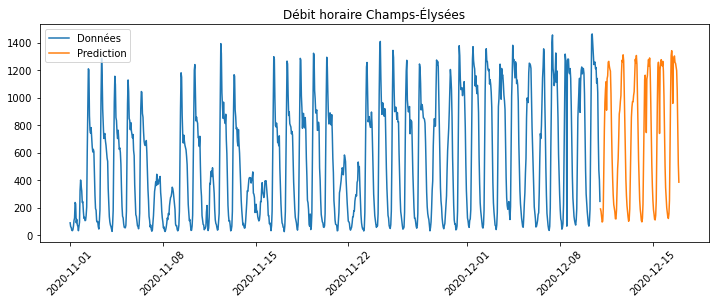

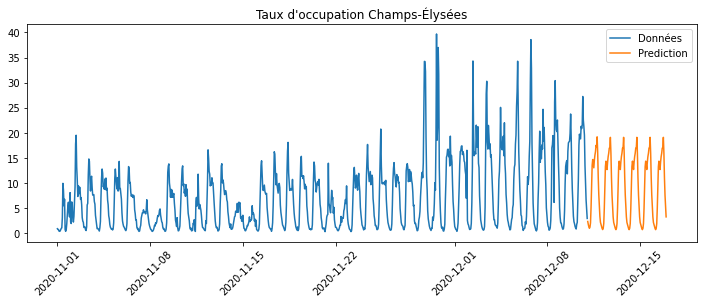

1it [30:00, 1800.61s/it]

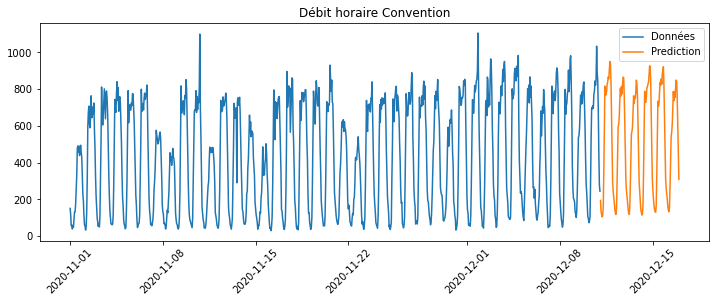

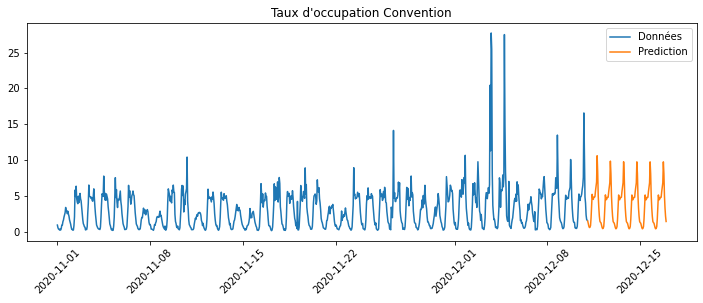

2it [1:01:31, 1827.62s/it]

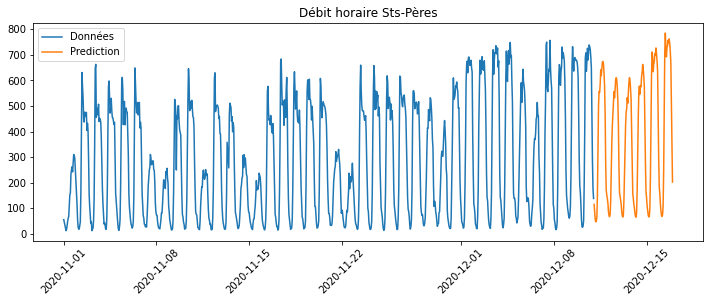

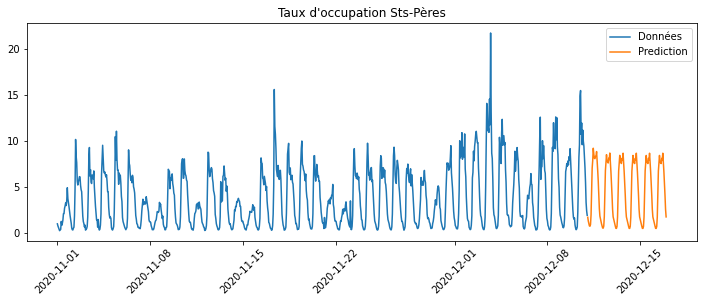

3it [1:31:14, 1824.82s/it]


In [58]:
df_predictions = pd.DataFrame()

for model_index,df in tqdm(enumerate([df_ACE, df_Sts, df_convention])):
    
    # Paramètres des modèles
    p_debit,d_debit,q_debit,seasonal_debit = string_to_model(modeles_debit[model_index])
    p_taux,d_taux,q_taux,seasonal_taux = string_to_model(modeles_taux[model_index])
    
    # Dates de prédiction
    start = datetime.strptime('2020-12-11 01:00:00', '%Y-%m-%d %H:%M:%S')
    end = datetime.strptime('2020-12-16 23:00:00', '%Y-%m-%d %H:%M:%S')
    
    # Dates de corréction
    start_dec = datetime.strptime('2020-12-09 00:00:00', '%Y-%m-%d %H:%M:%S')
    end_dec = datetime.strptime('2020-12-10 00:00:00', '%Y-%m-%d %H:%M:%S')
    
    # Création des timeseries pour débit horaire et taux d'occupation
    debit_train_raw = create_df(df).loc['2020-08-01':'2020-12-11 00:00:00'].debit
    taux_train_raw = create_df(df).loc['2020-08-01':'2020-12-11 00:00:00'].taux
        
    # Correction des données du 9 décembre
    mod_debit_corr = sm.tsa.statespace.SARIMAX(debit_train_raw.loc['2020-11-01':'2020-12-09 00:00:00'],order=(p_debit,d_debit,q_debit),seasonal_order=seasonal_debit,enforce_stationarity=False,enforce_invertibility=False)
    model_debit_corr = mod_debit_corr.fit()
    debit_correc = model_debit_corr.predict(start=start_dec,end=end_dec)
    
    mod_taux_corr = sm.tsa.statespace.SARIMAX(taux_train_raw.loc['2020-11-01':'2020-12-09 00:00:00'],order=(p_taux,d_taux,q_taux),seasonal_order=seasonal_taux,enforce_stationarity=False,enforce_invertibility=False)
    model_taux_corr = mod_taux_corr.fit()
    taux_correc = model_taux_corr.predict(start=start_dec,end=end_dec)
    
    # Correction des données:
    debit_train_raw[start_dec : end_dec] = debit_correc
    taux_train_raw[start_dec : end_dec] = taux_correc 
        
    # Ajustement du modèle pour le débit horaire
    mod_debit = sm.tsa.statespace.SARIMAX(debit_train_raw,order=(p_debit,d_debit,q_debit),seasonal_order=seasonal_debit,enforce_stationarity=False,enforce_invertibility=False)
    model_debit = mod_debit.fit()
    debit_pred = model_debit.predict(start=start,end=end)
    
    # Ajustement du modèle pour le taux d'occupation
    mod_taux = sm.tsa.statespace.SARIMAX(taux_train_raw,order=(p_taux,d_taux,q_taux),seasonal_order=seasonal_taux,enforce_stationarity=False,enforce_invertibility=False)
    model_taux = mod_taux.fit()
    taux_pred = model_taux.predict(start=start,end=end)
    
    # Rajout des données au DataFrame
    temp_df = pd.DataFrame()
    temp_df['Datetime'] = taux_pred.index
    temp_df['Arc'] = [tagg[model_index] for i in range(len(taux_pred))]
    temp_df["Débit horaire"] = debit_pred.values
    temp_df["Taux d'occupation"] = taux_pred.values
    
    # Rajout des données de minuit (une ligne)
    first_hour = pd.DataFrame()
    first_hour['Datetime'] = [taux_train.index[-1]]
    first_hour['Arc'] = [tagg[model_index]]
    first_hour["Taux d'occupation"] = [taux_train.values[-1]]
    first_hour["Débit horaire"] = [debit_train.values[-1]]
    
    temp_df = temp_df.append(first_hour)
    temp_df.sort_values("Datetime",inplace = True)
    df_predictions = pd.concat([df_predictions, temp_df])
        
    rcParams['figure.figsize'] = 12, 4
    plotting_predictions(debit_train_raw.loc['2020-11-01':'2020-12-11 00:00:00'], debit_pred, "Débit horaire " + tagg[model_index])
    plotting_predictions(taux_train_raw.loc['2020-11-01':'2020-12-11 00:00:00'], taux_pred, "Taux d'occupation " + tagg[model_index])
    
    
    
    

# Output en fichier CSV

In [59]:
df_predictions.to_csv('output.csv', index=False)

In [42]:
df_predictions.head()

,Datetime,Arc,Débit horaire,Taux d'occupation
0,2020-12-11 00:00:00,Champs-Élysées,247.000000,2.981110
0,2020-12-11 01:00:00,Champs-Élysées,175.105746,2.349191
1,2020-12-11 02:00:00,Champs-Élysées,129.010708,1.785235
2,2020-12-11 03:00:00,Champs-Élysées,68.825435,1.345536
3,2020-12-11 04:00:00,Champs-Élysées,22.530303,1.054927
